In [21]:
# import libraries
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from preprocessing import increase_saturation, gama_correction
from features import histogram_features, glcm_features
from visualization import plot_row

In [2]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [3]:
images = []
labels = []

# load images
for folder in os.listdir('dataset'):
    for file in os.listdir('dataset/' + folder):
        image = Image.open('dataset/' + folder + '/' + file)
        image = image.resize((256, 256))
        image = np.array(image)
        images.append(image)
        labels.append(folder)

In [4]:
classes = {'flooded': 1, 'non-flooded': 0}
inv_classes = {1: 'flooded', 0: 'non-flooded'}

labels = [classes[label] for label in labels]
images = np.array(images)
labels = np.array(labels)

In [5]:
# train test split
from sklearn.model_selection import train_test_split
X_train_images, X_test_images, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## PreProcessing

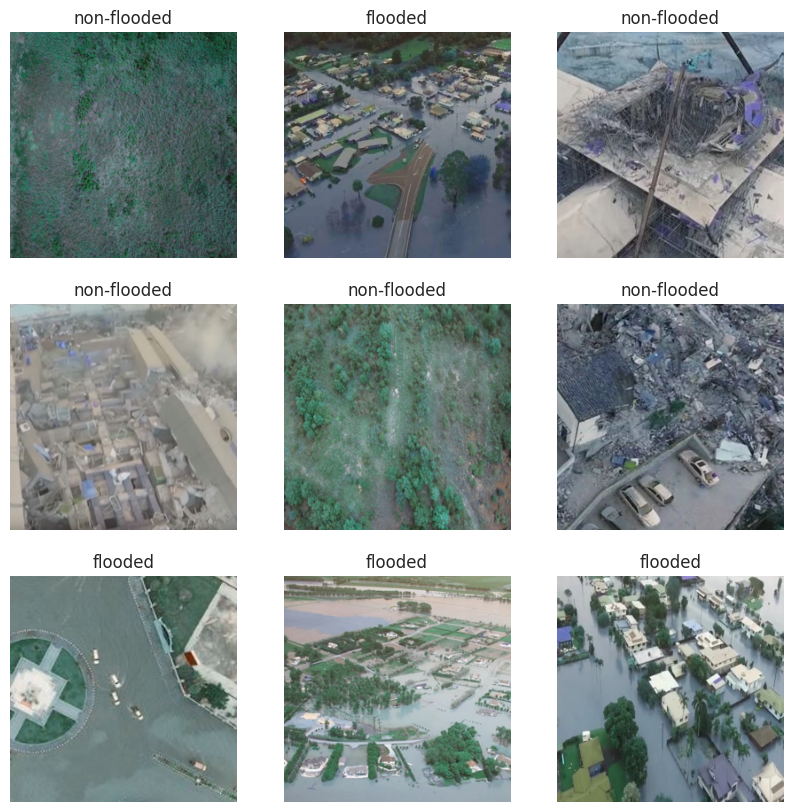

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train_images[i].astype("uint8"))
    plt.title(inv_classes[y_train[i]])
    plt.axis("off")

plt.show()

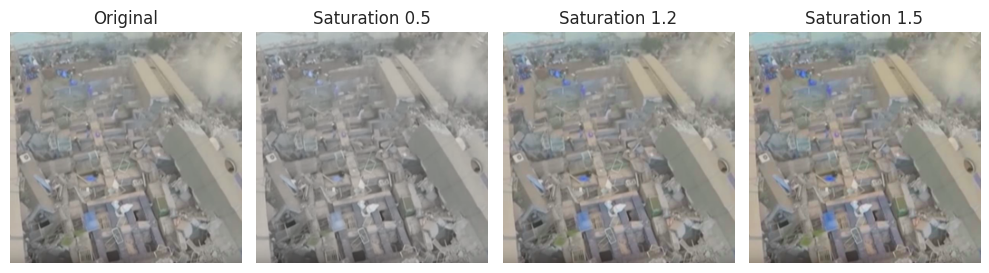

In [7]:
# increase saturation

values = [1, 0.5, 1.2, 1.5]
titles = ["Original" if value == 1 else "Saturation " + str(value) for value in values]
plot_row(
    [increase_saturation(X_train_images[3], value) for value in values],
    titles
)

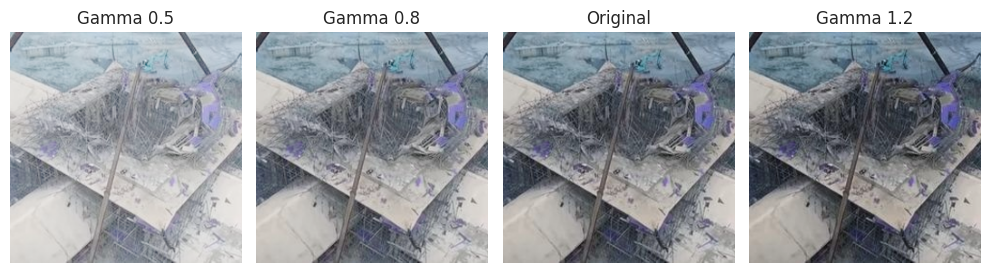

In [8]:
# gamma correction

values = [0.5, 0.8, 1, 1.2]
titles = ["Original" if value == 1 else "Gamma " + str(value) for value in values]
plot_row(
    [gama_correction(X_train_images[2], value) for value in values],
    titles
)

## Investigate Colors Features

In [9]:
# get colors distribution for each class
flooded = X_train_images[y_train == 1]
non_flooded = X_train_images[y_train == 0]

flooded_colors = []
for image in flooded:
    flooded_colors.append(np.mean(image, axis=(0, 1)))
flooded_colors = np.array(flooded_colors)

non_flooded_colors = []
for image in non_flooded:
    non_flooded_colors.append(np.mean(image, axis=(0, 1)))

non_flooded_colors = np.array(non_flooded_colors)

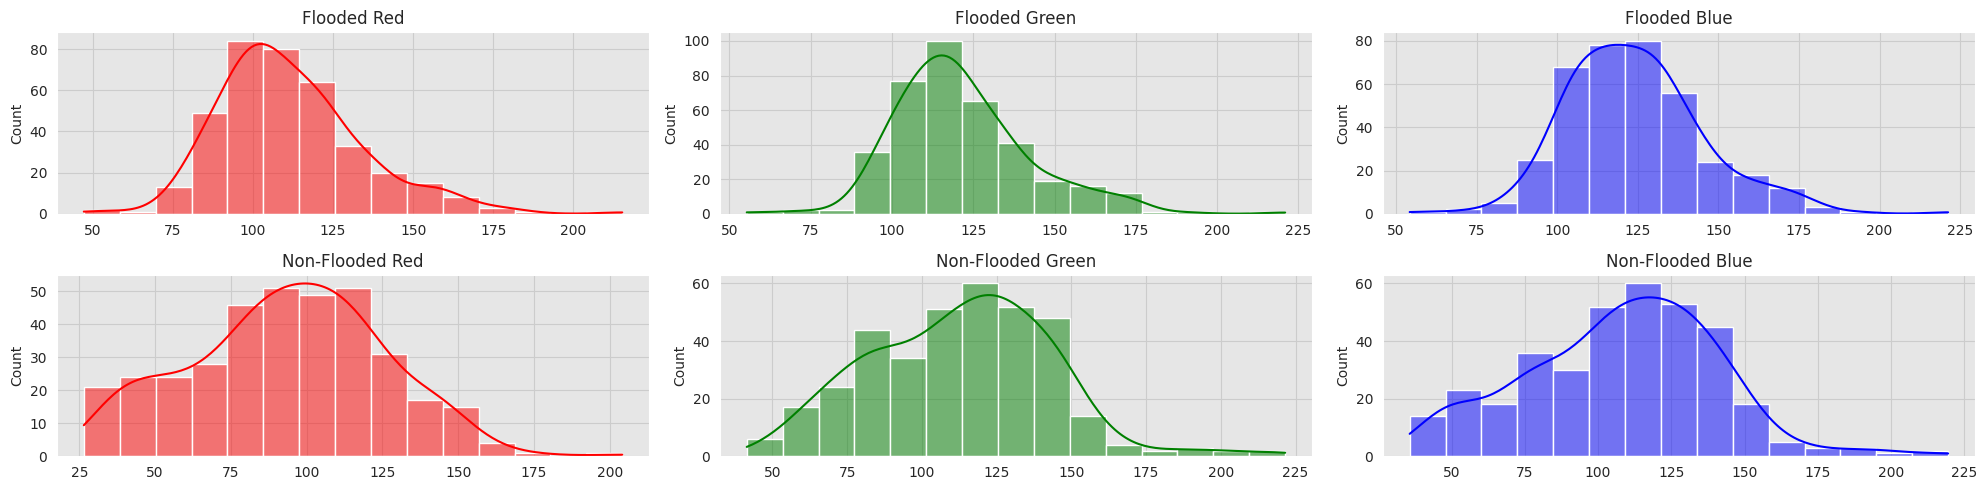

In [18]:
bins = 15
fig, ax = plt.subplots(2, 3, figsize=(20, 5))
sns.histplot(flooded_colors[:, 0], bins=bins, ax=ax[0, 0], color='red', kde=True)
sns.histplot(flooded_colors[:, 1], bins=bins, ax=ax[0, 1], color='green', kde=True)
sns.histplot(flooded_colors[:, 2], bins=bins, ax=ax[0, 2], color='blue', kde=True)
sns.histplot(non_flooded_colors[:, 0], bins=bins, ax=ax[1, 0], color='red', kde=True)
sns.histplot(non_flooded_colors[:, 1], bins=bins, ax=ax[1, 1], color='green', kde=True)
sns.histplot(non_flooded_colors[:, 2], bins=bins, ax=ax[1, 2], color='blue', kde=True)
ax[0, 0].set_title('Flooded Red')
ax[0, 1].set_title('Flooded Green')
ax[0, 2].set_title('Flooded Blue')
ax[1, 0].set_title('Non-Flooded Red')
ax[1, 1].set_title('Non-Flooded Green')
ax[1, 2].set_title('Non-Flooded Blue')
plt.tight_layout()
plt.show()

In [22]:
# make a vector feature for each image with first 15 bins of each color
bins = 15
X_train = []
for image in X_train_images:
    red = np.histogram(image[:, :, 0], bins=bins)[0]
    green = np.histogram(image[:, :, 1], bins=bins)[0]
    blue = np.histogram(image[:, :, 2], bins=bins)[0]
    X_train.append(np.concatenate((red, green, blue)))
X_train = np.array(X_train)

X_test = []
for image in X_test_images:
    red = np.histogram(image[:, :, 0], bins=bins)[0]
    green = np.histogram(image[:, :, 1], bins=bins)[0]
    blue = np.histogram(image[:, :, 2], bins=bins)[0]
    X_test.append(np.concatenate((red, green, blue)))
X_test = np.array(X_test)

In [24]:
clf = SVC(C=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8432432432432433
F1 Score: 0.8427838827838827


### GLCM Features

In [25]:
X_train = []
for image in X_train_images:
    X_train.append(glcm_features(image))
X_train = pd.DataFrame(X_train)

X_test = []
for image in X_test_images:
    X_test.append(glcm_features(image))
X_test = pd.DataFrame(X_test)

In [27]:
# train rf classifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))

Accuracy: 0.8378378378378378
F1 Score: 0.8378378378378378


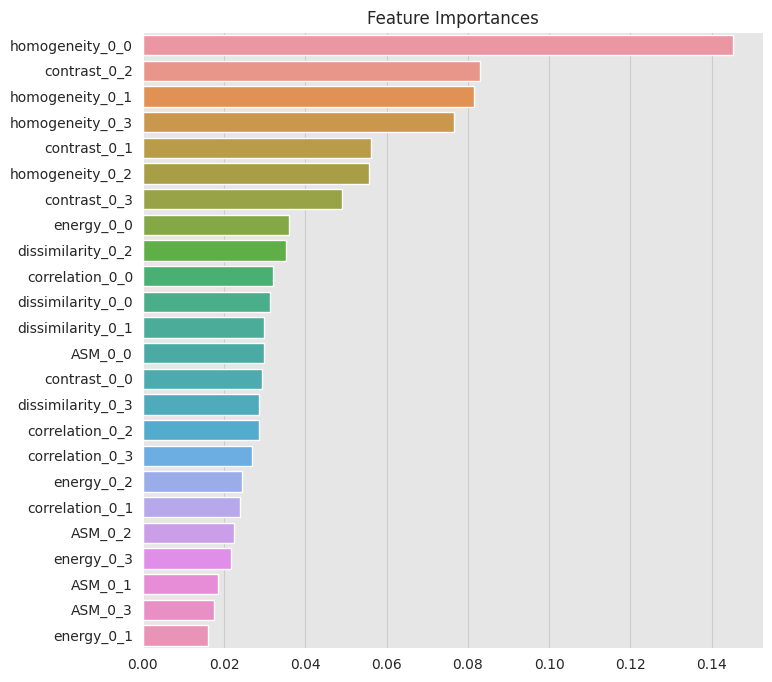

In [29]:
# get features importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=features[indices])
plt.show()

In [30]:
# retrain with only the homogeneity and  contrast features
features_to_extract = ['homogeneity', 'contrast'] 
X_train = []
for image in X_train_images:
    X_train.append(glcm_features(image, features_to_extract))
X_train = pd.DataFrame(X_train)

X_test = []
for image in X_test_images:
    X_test.append(glcm_features(image, features_to_extract))
X_test = pd.DataFrame(X_test)

In [31]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))

Accuracy: 0.8216216216216217
F1 Score: 0.8216216216216218


## LBP

In [32]:
from skimage import feature
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [33]:
# extract LBP features
desc = LocalBinaryPatterns(5, 10)
X_train = []
for image in X_train_images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    X_train.append(hist)
X_train = np.array(X_train)

X_test = []
for image in X_test_images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    X_test.append(hist)
X_test = np.array(X_test)

In [35]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7783783783783784
F1 Score: 0.7783524736273049


## PCA

In [36]:
# pca with different number of components and plot the explained variance
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X_train_images.reshape(-1, 256*256*3))

PCA(n_components=100)

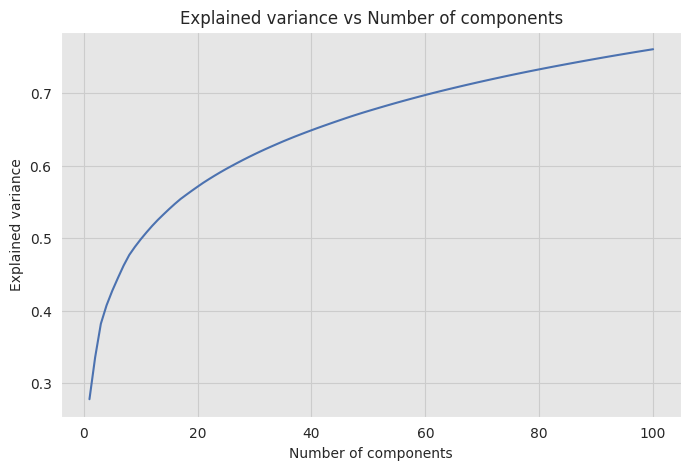

In [38]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 101), y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance vs Number of components')
plt.show()

In [45]:
# take 50 components
pca = PCA(n_components=50)
pca.fit(X_train_images.reshape(-1, 256*256*3))
X_train_pca = pca.transform(X_train_images.reshape(-1, 256*256*3))
X_test_pca = pca.transform(X_test_images.reshape(-1, 256*256*3))

clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.745945945945946
F1 Score: 0.7458271215177292


### HOG Features

In [56]:
# extract HOG features
from skimage.feature import hog
X_train = []
for image in X_train_images:
    hog_features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
    X_train.append(hog_features)
X_train = np.array(X_train)

X_test = []
for image in X_test_images:
    hog_features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
    X_test.append(hog_features)

X_test = np.array(X_test)

In [57]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7405405405405405
F1 Score: 0.739925023430178


## Final Features

In [92]:
# combine GLCM with LBP and color histogram
bins = 20
desc = LocalBinaryPatterns(5, 10)
X_train = []
for image in X_train_images:
    red = np.histogram(image[:, :, 0], bins=bins)[0]
    green = np.histogram(image[:, :, 1], bins=bins)[0]
    blue = np.histogram(image[:, :, 2], bins=bins)[0]
    glcm = glcm_features(image, features_to_extract)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist = desc.describe(gray)
    X_train.append(np.concatenate((red, green, blue, list(glcm.values()), hist)))

X_train = np.array(X_train)

X_test = []
for image in X_test_images:
    red = np.histogram(image[:, :, 0], bins=bins)[0]
    green = np.histogram(image[:, :, 1], bins=bins)[0]
    blue = np.histogram(image[:, :, 2], bins=bins)[0]
    glcm = glcm_features(image, features_to_extract)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist = desc.describe(gray)
    X_test.append(np.concatenate((red, green, blue, list(glcm.values()), hist)))

X_test = np.array(X_test)

In [100]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8864864864864865
F1 Score: 0.8860068659957161


In [101]:
# get classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['non-flooded', 'flooded']))

              precision    recall  f1-score   support

 non-flooded       0.89      0.90      0.89        98
     flooded       0.88      0.87      0.88        87

    accuracy                           0.89       185
   macro avg       0.89      0.89      0.89       185
weighted avg       0.89      0.89      0.89       185

